# Generate training samples for LDM

This notebook geneerate training samples (batch size = 1) for LDM.
* Training and validation samples were generated.
* Samples were saved as .npy files; their file names contain the datetime information.

In [1]:
import os
import sys
import time
import h5py
import numpy as np
from glob import glob
from datetime import datetime, timedelta

# ------------------------------------------------------- #
# Turn-off warnings
import logging
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ------------------------------------------------------- #
# Turn-off tensoflow-specific warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# ------------------------------------------------------- #
# Import customized modules and settings
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def norm_precip(x):
    return np.log(0.1*x+1)

## Import VQ-VAE encoder

In [4]:
# Hyperparameters
filter_nums = [64, 128] # number of convolution kernels per down-/upsampling layer 
latent_dim = 4 # number of latent feature channels
activation = 'gelu' # activation function
num_embeddings = 128 #128 # number of the VQ codes

input_size = (224, 464, 1) # size of MRMS input
latent_size = (14, 29, latent_dim) # size of compressed latent features

drop_encode = True
drop_decode = True

# location for saving new weights
model_name_encoder_load = model_dir+'models/VQ_VAE_encoder_stack1_tune0'
model_name_decoder_load = model_dir+'models/VQ_VAE_decoder_stack1_tune0'

model_encoder = mu.VQ_VAE_encoder_x4(input_size, filter_nums, latent_dim, num_embeddings, activation, drop_encode)

W_old = mu.dummy_loader(model_name_encoder_load)
model_encoder.set_weights(W_old)

## Generate training samples

* Locations: `$camp_dir/BATCH_LDM/`

In [5]:
BATCH_dir = camp_dir+'BATCH_LDM_NEW/'
batch_name = 'LDM_{}.npy' #.format(datetime)

LEADs = np.arange(6, 168+6, 6) # forecast lead times
N_leads = len(LEADs)

grid_shape = (N_leads, 14, 29, 4)
ccpa_shape = (224, 464)

with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
    land_mask_CCPA = h5io['land_mask_CCPA'][...]
land_mask_CCPA = land_mask_CCPA == 0

In [6]:
year = 2002

# ------------------------------------------------------- #
# Datetime information

base = datetime(year, 1, 1)

if year % 4 == 0:
    N_days = 366
else:
    N_days = 365

date_list = [base + timedelta(days=d) for d in range(N_days)]

In [7]:
filename_gefs = camp_dir+'GFS_reforecast/GEFS_AVE_y{}.hdf'
filename_ccpa = camp_dir+'CCPA/CCPA_y{}.hdf'

with h5py.File(filename_gefs.format(year), 'r') as h5io:
    GEFS = h5io['GEFS_APCP'][...] 

with h5py.File(filename_ccpa.format(year), 'r') as h5io:
    CCPA_base = h5io['CCPA'][...]
L_base = len(CCPA_base)

# forecast lead times can exceed one year
N_beyond = 5
N_total = L_base + N_beyond
with h5py.File(filename_ccpa.format(year+1), 'r') as h5io:
    CCPA_extra = h5io['CCPA'][:N_beyond, ...]

CCPA = np.concatenate((CCPA_base, CCPA_extra), axis=0)

GEFS = norm_precip(GEFS)
CCPA = norm_precip(CCPA)

GEFS[:, :, land_mask_CCPA] = 0.0
CCPA[:, :, land_mask_CCPA] = 0.0

### Import ViT

In [8]:
def ViT_pred(x, model_48, model_96, model_144):
    Y_pred_48 = model_48.predict(x[0:8, ...][None, ...], verbose=0)
    Y_pred_96 = model_96.predict(x[8:16, ...][None, ...], verbose=0)
    Y_pred_144 = model_144.predict(x[16:24, ...][None, ...], verbose=0)
    Y_pred = np.concatenate((Y_pred_48, Y_pred_96, Y_pred_144), axis=1)
    return Y_pred[0, ...]

In [9]:
# The tensor size of embedded CCPA and GEFS ensemble mean 
latent_size = (14, 29, 4)
# input size for the 48h models
input_size = (8,) + latent_size

# patch size
patch_size = (1, 1, 1) # (time, space, space)

N_heads = 4
N_layers = 8
project_dim = 128

# location of the previous weights
model_name_load = model_dir+'models/ViT3d_0_48_depth{}_patch{}{}{}_dim{}_heads{}_tune'.format(
    N_layers, patch_size[0], patch_size[1], patch_size[2], project_dim, N_heads)

In [10]:
ViT = mu.ViT3d_corrector(input_size, patch_size, project_dim, N_layers, N_heads)

W_old = mu.dummy_loader(model_name_load)
ViT.set_weights(W_old)

## Generate training batches

In [1]:
GEFS_embed = np.empty(grid_shape)
CCPA_embed = np.empty(grid_shape)
CCPA_true = np.empty((N_leads,)+land_mask_CCPA.shape)

for d, dt in enumerate(date_list):
    dt_str = datetime.strftime(dt, '%Y%m%d')
    GEFS_embed[...] = np.nan
    CCPA_embed[...] = np.nan
    
    for ilead, lead in enumerate(LEADs):
        d_ = lead // 24; day = d + d_
        ind_hour = lead % 24; ind_hour = int(ind_hour/6)

        CCPA_true[ilead, ...] = CCPA[day, ind_hour, ...]
        ccpa_input = CCPA[day, ind_hour, ...][None, ..., None]
        gefs_input = GEFS[d, ilead, ...][None, ..., None]

        if np.sum(np.isnan(ccpa_input)) + np.sum(np.isnan(gefs_input)) == 0:
            CCPA_embed[ilead, ...] = model_encoder.predict(ccpa_input, verbose=0)[0, ...]
            GEFS_embed[ilead, ...] = model_encoder.predict(gefs_input, verbose=0)[0, ...]
        else:
            CCPA_embed[ilead, ...] = np.nan
            GEFS_embed[ilead, ...] = np.nan

    if np.sum(np.isnan(CCPA_embed)) + np.sum(np.isnan(GEFS_embed)) == 0:
        ViT_embed = ViT_pred(GEFS_embed, ViT, ViT, ViT)
        
        data_save = {}
        data_save['CCPA_true'] = CCPA_true
        data_save['CCPA_embed'] = CCPA_embed
        data_save['GEFS_embed'] = GEFS_embed
        data_save['ViT_embed'] = ViT_embed
        save_name_ = BATCH_dir+batch_name.format(dt_str)
        print(save_name_)
        np.save(save_name_, data_save)
        if d == 5:
            raise

### Check batch quality

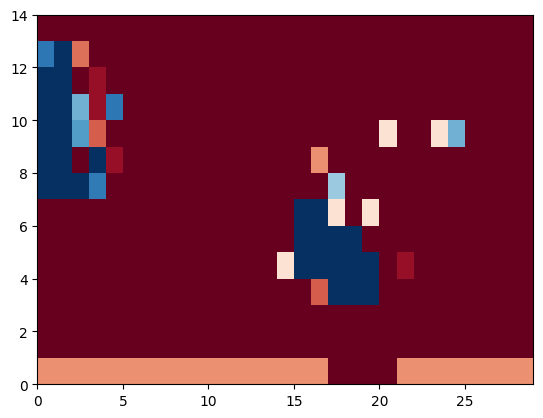

In [17]:
plt.pcolormesh(data_save['CCPA_embed'][0, ..., 0], vmin=-0.1, vmax=0.1, cmap=plt.cm.RdBu_r)

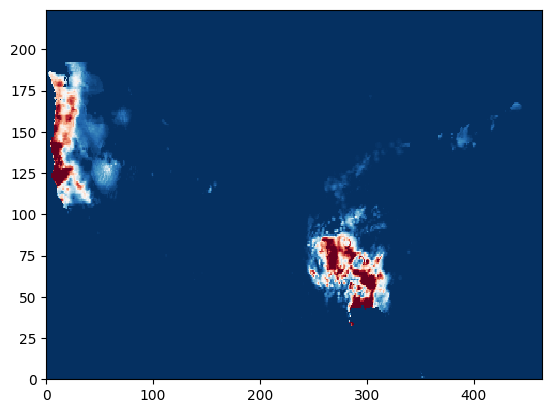

In [16]:
plt.pcolormesh(data_save['CCPA_true'][0, ...], vmin=0, vmax=1, cmap=plt.cm.RdBu_r)

In [15]:
data_save['CCPA_true'].shape

(28, 224, 464)